In [2]:
import os
import numpy as np
import pandas as pd
import keras
import shutil

import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization
from keras.layers import Activation, ZeroPadding2D, Add, Concatenate

from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras.backend as K

In [3]:
image_path = 'celeba-dataset/img_align_celeba'
attributes_path = 'celeba-dataset/list_attr_celeba.csv'
image_folder = 'categories'

### Load attribute data:

In [4]:
attributes_df = pd.read_csv(attributes_path)
attributes_df.columns.values

array(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair',
       'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee',
       'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male',
       'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair',
       'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'], dtype=object)

In [5]:
attributes_to_keep = ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair', 'Male']
attribute_data = attributes_df[attributes_to_keep]
attribute_data = attribute_data.values # note that index starts with 0 and image id with 1!


### Load image data:



### Define data generators

In [14]:
target_size = (128, 128)
input_shape = (target_size[0], target_size[1], 3)
batch_size = 16

data_generator = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)

train_generator = data_generator.flow_from_directory(image_folder, 
                                                     target_size=target_size, 
                                                     batch_size=batch_size)


KeyboardInterrupt: 

In [15]:
x, y = train_generator.next()
y = np.argmax(y, axis = 1)

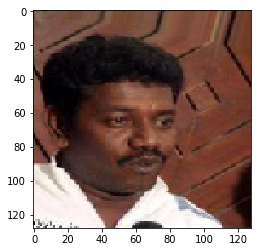

In [16]:
plt.imshow(x[10])

## Define networks:


### Parameters

In [13]:
noise_size = 100
epochs = 10
save_interval = 1
batch_size = 512
#batches_per_epoch = train_generator.n // batch_size
train_generator= None
data_generator = None
optimizer = Adam(0.0002, 0.5)
batches_per_epoch = 5

In [7]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true*y_pred)

### Generate models!

In [14]:
noise_size = 100
nbr_of_features = 5
in_features = Input(shape=[nbr_of_features])
noise_input = Input(shape=[noise_size])

def generator_input_model(noise_size, nbr_input_features):
    generator_input = Concatenate()([noise_input, in_features])
    #generator_input = Input(shape=[latent_dim + nbr_input_features])
    fc = Dense(16*16*3)(generator_input)
    #fc = Dense(16*16*3, activation='sigmoid')(generator_input)
    fc = LeakyReLU(alpha=0.2)(fc)
    image = Reshape((16,16,3))(fc)
    image = Conv2D(3, kernel_size=3, padding="same")(image)
    image = LeakyReLU(alpha=0.2)(image)
    image = Conv2D(3, kernel_size=3, padding="same")(image)
    image = LeakyReLU(alpha=0.2)(image)
    image = Conv2D(3, kernel_size=3, padding="same")(image)
    image = BatchNormalization()(image)
    image = Activation('sigmoid')(image)
    return Model([noise_input, in_features], image)

def generator_conv_block(input_shape):
    image_input = Input(shape=input_shape)
    image = UpSampling2D()(image_input)
    image = Conv2D(3, kernel_size=3, padding="same")(image)
    image = LeakyReLU(alpha=0.2)(image)
    image = Conv2D(3, kernel_size=3, padding="same")(image)
    image = LeakyReLU(alpha=0.2)(image)
    image = Conv2D(3, kernel_size=3, padding="same")(image)
    image = BatchNormalization()(image)
    image = Activation('sigmoid')(image)
    #image = LeakyReLU(alpha=0.2)(image)
    return Model(image_input, image)

def create_discriminator_classifier(nbr_input_features):
    fc_size = (8*8*3 + nbr_input_features )// 2
    image_input = Input(shape=(8,8,3))
    image_flat = Flatten()(image_input)
    
    classifier_input = Concatenate()([image_flat, in_features])
    
    hidden = Dense(fc_size)(classifier_input)
    hidden = LeakyReLU(alpha=0.2)(hidden)
    out = Dense(1, activation='sigmoid')(hidden)
    
    return Model([image_input, in_features], out)

def discriminator_conv_block(input_shape):
    image_input = Input(shape=input_shape)
    image = Conv2D(3, kernel_size=5, padding="same")(image_input)
    image = LeakyReLU(alpha=0.2)(image)
    image = Conv2D(3, kernel_size=5, padding="same")(image)
    image = LeakyReLU(alpha=0.2)(image)
    image = Conv2D(3, kernel_size=5, padding="same", strides=2)(image)
    image = BatchNormalization()(image)
    image = LeakyReLU(alpha=0.2)(image)
    return Model(image_input, image)


def next_generator_model(previous_model):
    new_block = generator_conv_block(previous_model.output_shape[1:])
    #new_out = new_block(previous_model)
    old_out = previous_model([noise_input, in_features])
    new_out = new_block(old_out)
    new_model = Model([noise_input, in_features], new_out)
    return new_model

def next_discriminator_cnn(previous_cnn_network):
    previous_image_size = previous_cnn_network.input_shape[1]
    input_shape = (previous_image_size*2, previous_image_size*2, 3)
    new_block = discriminator_conv_block(input_shape)
    new_cnn_model = Sequential()
    new_cnn_model.add(new_block)
    new_cnn_model.add(previous_cnn_network)
    return new_cnn_model

#discriminator = Model([in_image, in_features], discriminator_classifier([current_discriminator_cnn(in_image), in_features]))


In [20]:
def plot_history(d_loss_hist, g_loss_hist):
    
    plt.figure()
    plt.plot(d_loss_hist, label='Discriminator')
    plt.plot(g_loss_hist, label='Generator')
    plt.xlabel('Epochs')
    plt.legend(loc='best')
    plt.title('Loss over epochs')
    
feature_matrix = attribute_data[0:25,:]

def numpy_rescaled(x):
    out = x.copy()
    out[x<0] = 0
    out[x>1] = 1
    return out

def save_imgs(epoch, generator):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, noise_size))
    gen_imgs = generator.predict([noise, feature_matrix])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,:])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/celebA_%d.png" % epoch)
    plt.close()

def train_gan(discriminator, generator, combined_model, epochs=10, batches_per_epoch=None):
    if batches_per_epoch is None:
        batches_per_epoch = train_generator.n // batch_size


    d_loss_hist = list()
    g_loss_hist = list()
    for epoch in range(epochs):
       
        for i_batch in range(batches_per_epoch):
        # Select a random batch of images
            imgs, y = train_generator.next()
            # one hot to feature
            y = np.argmax(y, axis = 1)
            input_features = attribute_data[y, :]
            
            b_size = imgs.shape[0]
            valid = np.ones((b_size, 1))
            fake = np.zeros((b_size, 1))

            if i_batch%40 == 0:
                print('Currently on batch: %d for epoch: %d' % (i_batch, epoch))

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (b_size, noise_size))
            # Generator features
            
            gen_imgs = generator.predict([noise, input_features])
            
            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = discriminator.train_on_batch([imgs, input_features], valid)
            d_loss_fake = discriminator.train_on_batch([gen_imgs, input_features], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = combined_model.train_on_batch([noise, input_features], valid)

        d_loss_hist.append(d_loss[0])
        g_loss_hist.append(g_loss)
        # Plot the progress
        print ("epoch: %d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch, generator)
    
    return d_loss_hist, g_loss_hist

## Step 1

In [15]:
step = 1
# First generator step
current_generator_model = generator_input_model(noise_size, nbr_of_features)
#current_generator_model.summary()

# First Discriminator step, only classifier
discriminator_classifier = create_discriminator_classifier(nbr_of_features)
#discriminator_classifier.summary()

current_discriminator_cnn = discriminator_conv_block((16, 16, 3))
in_image = Input(shape=current_generator_model.output_shape[1:])
discriminator = Model([in_image, in_features], discriminator_classifier([current_discriminator_cnn(in_image), in_features]))
#discriminator.summary()




Train step 1

In [16]:
target_size = (16, 16)
input_shape = (target_size[0], target_size[1], 3)

def get_data_generators(image_size):
    data_generator = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)

    train_generator = data_generator.flow_from_directory(image_folder, 
                                                         target_size=(image_size, image_size), 
                                                         batch_size=batch_size)
    return data_generator, train_generator


In [17]:
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=optimizer,
                      metrics=['accuracy'])

# The generator takes noise as input and generates imgs
noise_input = Input(shape=[noise_size])
img = current_generator_model([noise_input, in_features])

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator([img, in_features])

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model([noise_input, in_features], valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

In [18]:
data_generator, train_generator = get_data_generators(16)

Found 202599 images belonging to 202599 classes.


Currently on batch: 0 for epoch: 0


/home/student/anaconda3/envs/dml_gpu/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0 [D loss: 0.846887, acc.: 49.32%] [G loss: 0.392117]
Currently on batch: 0 for epoch: 1
epoch: 1 [D loss: 0.791954, acc.: 48.44%] [G loss: 0.507958]
Currently on batch: 0 for epoch: 2
epoch: 2 [D loss: 0.793769, acc.: 42.68%] [G loss: 0.543809]
Currently on batch: 0 for epoch: 3
epoch: 3 [D loss: 0.775456, acc.: 42.97%] [G loss: 0.590698]
Currently on batch: 0 for epoch: 4
epoch: 4 [D loss: 0.763226, acc.: 45.12%] [G loss: 0.641415]
Currently on batch: 0 for epoch: 5
epoch: 5 [D loss: 0.717935, acc.: 50.10%] [G loss: 0.706335]
Currently on batch: 0 for epoch: 6
epoch: 6 [D loss: 0.695726, acc.: 53.91%] [G loss: 0.770683]
Currently on batch: 0 for epoch: 7
epoch: 7 [D loss: 0.661946, acc.: 60.06%] [G loss: 0.827848]
Currently on batch: 0 for epoch: 8
epoch: 8 [D loss: 0.631040, acc.: 65.14%] [G loss: 0.872002]
Currently on batch: 0 for epoch: 9
epoch: 9 [D loss: 0.625866, acc.: 65.82%] [G loss: 0.888485]


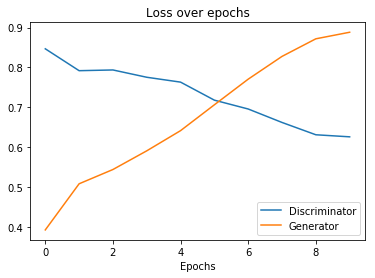

In [21]:
d_loss_hist, g_loss_hist = train_gan(discriminator, current_generator_model, combined, epochs=epochs, batches_per_epoch=batches_per_epoch)
plot_history(d_loss_hist, g_loss_hist)

Save the models from step 1

In [22]:
current_generator_model.save('generator_model_step%d.h5' %step)
discriminator_classifier.save('discriminator_classifier_step%d.h5' %step)
current_discriminator_cnn.save('current_discriminator_cnn_step%d.h5' %step)

# Step 2, 3, .....

In [23]:
step += 1
# Generator step  
current_generator_model.trainable = False
previous_generator_model = current_generator_model 
current_generator_model = next_generator_model(previous_generator_model)

# Discriminator step
in_image = Input(shape=current_generator_model.output_shape[1:]) # Input size should be equal to generator output size
previous_discriminator_cnn = current_discriminator_cnn # Save old cnn
current_discriminator_cnn = next_discriminator_cnn(previous_discriminator_cnn)
# Put the discriminator together
discriminator = Model([in_image, in_features], discriminator_classifier([current_discriminator_cnn(in_image), in_features]))


In [24]:
current_generator_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
model_6 (Model)                 (None, 16, 16, 3)    81672       input_12[0][0]                   
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
model_11 (Model)                (None, 32, 32, 3)    264         model_6[2][0]                    
Total para

In [25]:
data_generator, train_generator = get_data_generators(current_generator_model.output_shape[1])

Found 202599 images belonging to 202599 classes.


In [26]:
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=optimizer,
                      metrics=['accuracy'])

# The generator takes noise as input and generates imgs
#noise_input = Input(shape=[noise_size])
img = current_generator_model([noise_input, in_features])

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator([img, in_features])

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model([noise_input, in_features], valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

In [ ]:
d_loss_hist, g_loss_hist = train_gan(discriminator, current_generator_model, combined, epochs=epochs, batches_per_epoch=batches_per_epoch)
plot_history(d_loss_hist, g_loss_hist)

Currently on batch: 0 for epoch: 0


/home/student/anaconda3/envs/dml_gpu/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0 [D loss: 0.626418, acc.: 63.77%] [G loss: 0.964984]
Currently on batch: 0 for epoch: 1
epoch: 1 [D loss: 0.420187, acc.: 84.47%] [G loss: 1.242720]
Currently on batch: 0 for epoch: 2
epoch: 2 [D loss: 0.341948, acc.: 89.06%] [G loss: 1.509195]
Currently on batch: 0 for epoch: 3
epoch: 3 [D loss: 0.284640, acc.: 92.19%] [G loss: 1.692387]
Currently on batch: 0 for epoch: 4
epoch: 4 [D loss: 0.255456, acc.: 92.58%] [G loss: 1.824259]
Currently on batch: 0 for epoch: 5
epoch: 5 [D loss: 0.245221, acc.: 92.97%] [G loss: 1.900806]
Currently on batch: 0 for epoch: 6
epoch: 6 [D loss: 0.230529, acc.: 93.65%] [G loss: 2.071171]
Currently on batch: 0 for epoch: 7
epoch: 7 [D loss: 0.202123, acc.: 94.43%] [G loss: 2.198757]
Currently on batch: 0 for epoch: 8
epoch: 8 [D loss: 0.204696, acc.: 93.65%] [G loss: 2.387258]
Currently on batch: 0 for epoch: 9


In [32]:
discriminator.trainable = True
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=optimizer,
                      metrics=['accuracy'])

# The generator takes noise as input and generates imgs
#noise_input = Input(shape=[noise_size])
current_generator_model.trainable = True
img = current_generator_model([noise_input, in_features])

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator([img, in_features])

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model([noise_input, in_features], valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
model_10 (Model)                (None, 16, 16, 3)    5280        input_5[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
model_14 (Model)                (None, 32, 32, 3)    96          model_10[2][0]                   
Total para

In [ ]:
d_loss_hist, g_loss_hist = train_gan(discriminator, current_generator_model, combined, epochs=epochs, batches_per_epoch=batches_per_epoch)
plot_history(d_loss_hist, g_loss_hist)

In [ ]:
current_generator_model.save('generator_model_step%d.h5' %step)
discriminator_classifier.save('discriminator_classifier_step%d.h5' %step)
current_discriminator_cnn.save('current_discriminator_cnn_step%d.h5' %step)